**Instituto Tecnológico de Costa Rica**

**Escuela de Ingeniería en Computación**

**Maestría Académica en Ciencias de la Computación**

**Curso: Electiva Aprendizaje Automático**

**Segundo Semestre 2025**

**Profesor:** Dr. Luis-Alexander Calvo-Valverde

---

**Trabajo Práctico:** 3

**Datos de la entrega:** Jueves 13 de noviembre 2025, a más tardar a las 6:00 pm

**Medio de entrega**: Por medio del TEC-Digital.

**Entregables**: Un archivo jupyter (`.ipynb`) y todos los archivos adicionales que se requieran para correr su cuaderno (En un archivo comprimido).

---

**Estudiantes:**
- David Alberto Guevara Sánchez
- Kenneth Barboza Corrales

# Nota Introductoria.

Usted puede cambiar el dataset que se le proporciona por otro de su interés; pero de hacerlo, se le recomienda valorarlo con el profesor para que su dataset no le agregue una complicación importante al Trabajo Práctico.

___

# Parte 1  -  Clustering en imágenes de emociones

### Considere lo siguiente:
1. Conjunto de datos: `datos_imagenes_USAR.csv`
1. Este dataset corresponde a pixeles en imágenes, a partir de las cuales se desea descubrir cuántos grupos (clusters) se podrían encontrar. Se cree que son diferentes emociones de las personas en las imágenes (alegría, enojo, tristeza, etc).
1. Proponga al menos dos algoritmo a utilizar
1. Proponga dos métricas, las cuales deben ser **internas**.
1. Debe presentar en este cuaderno:
    1. Pre-procesamiento de los datos, explicando las decisiones en cada caso. Observará que en este caso viene bastante preparado pero Usted puede proponer un pre-procesado que según el estado del arte podría mejorar el agrupamiento.
    1. Para cada algoritmo seleccionado:
        1. Explicación del algoritmo.
        1. Explicación de la implementación seleccionada y de sus parámetros.
    1. Explicación del diseño experimental por ejecutar. En este caso recuerde que es aprendizaje NO Supervisado. **Además en cuanto al número de clusters, se cree que es mayor que uno y menor que veinte**.
    1. Programación del diseño experimental.
    1. Muestre en una tabla los resultados de las métricas.
    1. Grafique para ver el criterio del codo para cada algoritmo.

---

Primero iniciamos haciendo la importación de las librerías.

In [21]:
from dataclasses import dataclass
from typing import Literal, Optional

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from matplotlib.axes import Axes
from numpy.typing import ArrayLike, NDArray
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

Y luego de eso cargamos el _dataset_. Con `df.head()` podemos ver que el _dataset_ posee 2304 columnas, las cuales representan pixeles, siendo cada columna una imagen de 48x48 pixeles ($2304 = 48 * 48$) en escala de grises con un solo canal (0-255).

Con `len(df)` podemos ver que el dataset posee 35887 filas, las cuales representan la cantidad de imágenes en el _dataset_.

In [2]:
df_raw = pd.read_csv("data/datos_imagenes_USAR.csv", sep=";", dtype="uint8")
display(df_raw.head())
display(len(df_raw))

,pixels,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 2294,Unnamed: 2295,Unnamed: 2296,Unnamed: 2297,Unnamed: 2298,Unnamed: 2299,Unnamed: 2300,Unnamed: 2301,Unnamed: 2302,Unnamed: 2303
0,70,80,82,72,58,58,60,63,54,58,...,159,182,183,136,106,116,95,106,109,82
1,151,150,147,155,148,133,111,140,170,174,...,105,108,95,108,102,67,171,193,183,184
2,231,212,156,164,174,138,161,173,182,200,...,104,138,152,122,114,101,97,88,110,152
3,24,32,36,30,32,23,19,20,30,41,...,174,126,132,132,133,136,139,142,143,142
4,4,0,0,0,0,0,0,0,0,0,...,12,34,31,31,31,27,31,30,29,30


35887

Con el siguiente código creamos una función que nos permite convertir una fila del _dataset_ a una imagen y mostrarla, para tener una idea de cómo se ven las imágenes en el _dataset_.

In [3]:
def show_row(row: ArrayLike, size: tuple[int, int] = (48, 48), ax: Axes | None = None):
    """
    Shows an image in a row of the dataset.
    """
    pixels = np.asarray(row, dtype=np.uint8)
    image = pixels.reshape(size)

    standalone = ax is None

    if standalone:
        _, ax = plt.subplots(1, 1, figsize=(3, 3))

    ax.imshow(image, cmap="gray", vmin=0, vmax=255)
    ax.axis("off")

    if standalone:
        plt.show()

Y así podemos ver la imagen con el índice $33$ del _dataset_:

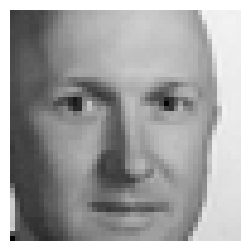

In [4]:
show_row(df_raw.iloc[33])

Con esto podemos ver que el _dataset_ contiene fotos de caras en blanco y negro a como analizamos anteriormente.

## Filtrado de datos en el _dataset_

Luego de esto realizamos una eliminación de filas duplicadas. Al ejecutar este código pudimos ver que habían 1853 filas duplicadas.

In [5]:
df_no_dup = df_raw.drop_duplicates()
print(len(df_raw) - len(df_no_dup))

1853


También verificamos que no hayan valores faltantes y que el rango de valores sea el esperado.

In [6]:
# Check for missing values
print(f"Missing values: {df_no_dup.isnull().sum().sum()}")
# Check for invalid pixel ranges (should be 0-255)
print(f"Min pixel value: {df_no_dup.min().min()}")
print(f"Max pixel value: {df_no_dup.max().max()}")

Missing values: 0
Min pixel value: 0
Max pixel value: 255


Al ejecutar este código vimos que no hay valores faltantes y el rango es el esperado.

También, otro tipo de filas que deberíamos filtrar son las que poseen imágenes con poca varianza. Con el código a continuación podemos ver un histograma y un diagrama de cajas de la varianza de las imágenes.

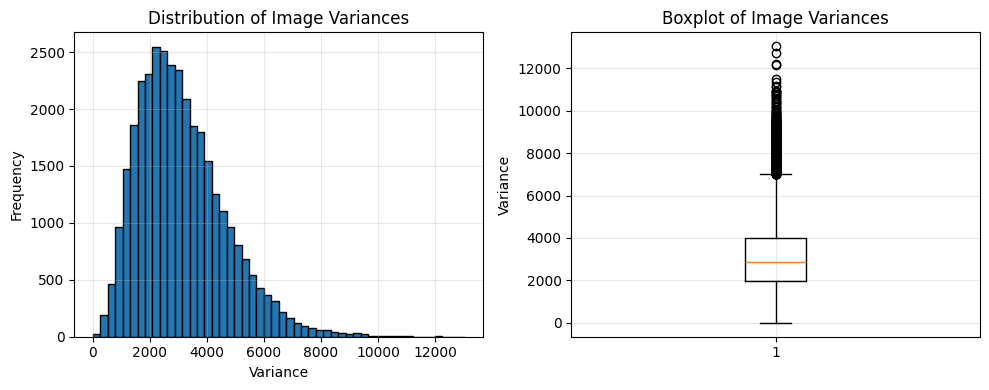

count    34034.000000
mean      3107.510894
std       1536.703923
min          0.000000
25%       1978.128447
50%       2872.296935
75%       3984.541672
max      13036.335642
dtype: float64

In [7]:
var = df_no_dup.var(axis=1)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(var, bins=50, edgecolor="black")
plt.xlabel("Variance")
plt.ylabel("Frequency")
plt.title("Distribution of Image Variances")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(var)
plt.ylabel("Variance")
plt.title("Boxplot of Image Variances")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

var.describe()

Con esto podemos ver que hay algunas imágenes con muy poca varianza, así que podemos filtrar las imágenes que están en el 1% de menor varianza. Antes de esto primero mostramos algunas de las imágenes con poca varianza:

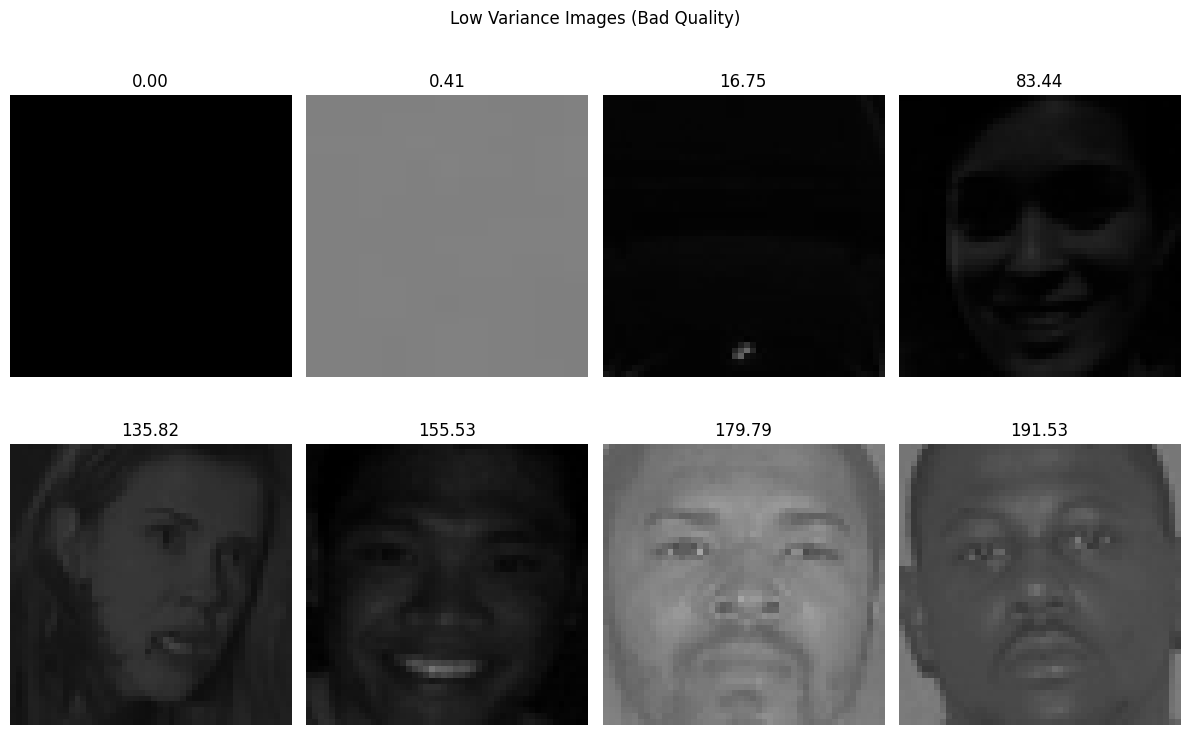

In [8]:
low_var_idx = var.nsmallest(8).index
fig, axs = plt.subplots(2, 4, figsize=(12, 8))
for ax, idx in zip(axs.flat, low_var_idx):
    show_row(df_no_dup.loc[idx], ax=ax)
    ax.set_title(f"{var[idx]:.2f}")
plt.suptitle("Low Variance Images (Bad Quality)")
plt.tight_layout()
plt.show()

Una vez que observamos las imágenes con peor varianza, podemos ver que estas imágenes o no tienen caras o están muy oscuras como para poder observar las caras adecuadamente. Con el siguiente código procedemos a filtrar las imágenes en el percentil 1%.

In [9]:
percentile = 1  # Remove bottom 1%
threshold_percentile = var.quantile(percentile / 100)
df_no_low_var = df_no_dup[var > threshold_percentile]
print(f"Removed {len(df_no_dup) - len(df_no_low_var)} images (bottom {percentile}%)")
print(f"Remaining: {len(df_no_low_var)} images ({len(df_no_low_var) / len(df_raw) * 100:.2f}% of original)")

Removed 341 images (bottom 1%)
Remaining: 33693 images (93.89% of original)


Para contrastar aquí están algunas de las imágenes con mayor varianza:

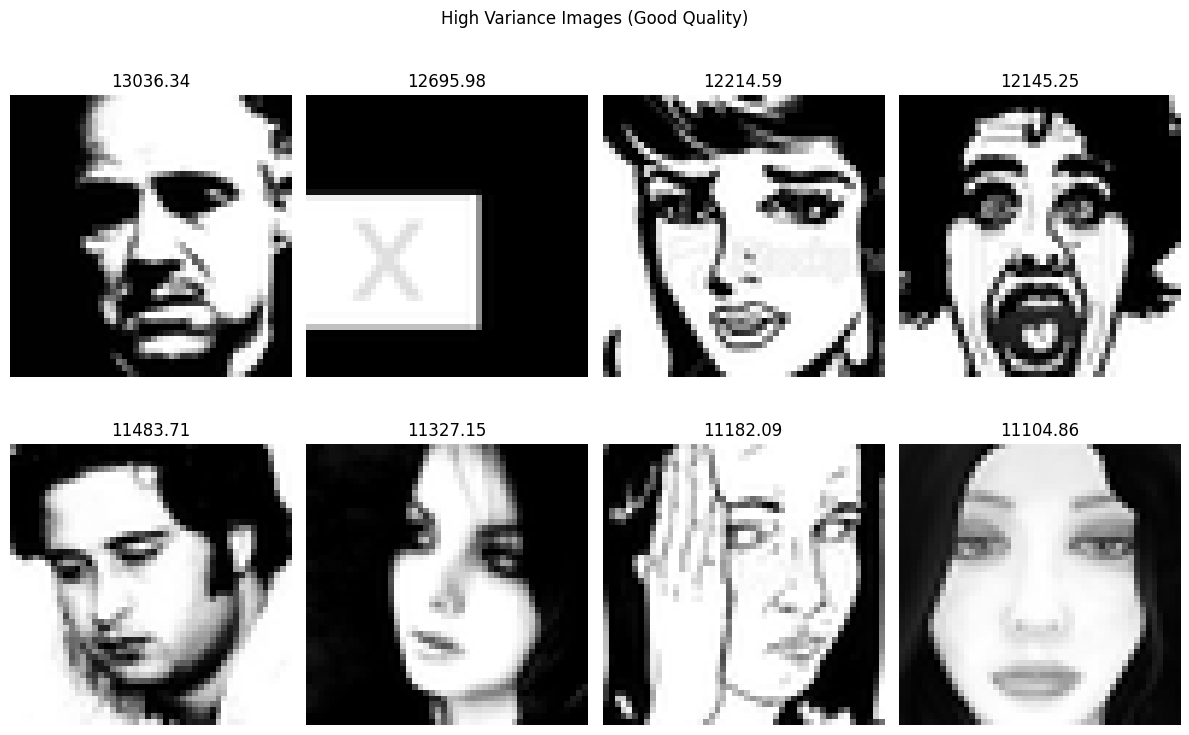

In [10]:
high_var_idx = var.nlargest(8).index
fig, axs = plt.subplots(2, 4, figsize=(12, 8))
for ax, idx in zip(axs.flat, high_var_idx):
    show_row(df_no_dup.loc[idx], ax=ax)
    ax.set_title(f"{var[idx]:.2f}")
plt.suptitle("High Variance Images (Good Quality)")
plt.tight_layout()
plt.show()

## Pre-procesamiento de datos

Antes de iniciar con el preprocesamiento algo que es recomendado es hacer _histogram equalization_, la cual es una técnica estándar en reconocimiento de expresiones faciales. Para esto vamos a hacer uso de la librería `opencv-python`.

In [11]:
images = df_no_low_var.to_numpy(dtype=np.uint8).reshape(-1, 48, 48)
images_eq = np.array([cv2.equalizeHist(img) for img in images])
df_eq = pd.DataFrame(images_eq.reshape(len(df_no_low_var), -1), index=df_no_low_var.index)

A continuación podemos ver la misma imagen que mostramos anteriormente, en una comparación de antes y después.

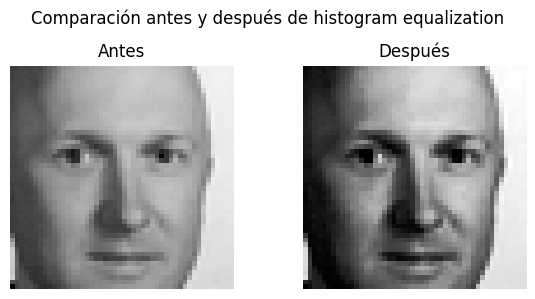

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))

show_row(df_no_low_var.iloc[33], ax=axs[0])
axs[0].set_title("Antes")
show_row(df_eq.iloc[33], ax=axs[1])
axs[1].set_title("Después")

plt.suptitle("Comparación antes y después de histogram equalization")
plt.tight_layout()
plt.show()

Una vez realizamos esto podemos proceder a realizar la normalización de los datos. Para esto vamos a utilizar `StandardScaler`.

In [13]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_eq), index=df_eq.index, columns=df_eq.columns)

print(f"Mean: {df_scaled.mean().mean():.6f}")
print(f"Std: {df_scaled.std().mean():.6f}")

Mean: -0.000000
Std: 1.000015


Para visualización, creamos una función que permite revertir el proceso de normalización para poder usarla junto con `show_row`.

In [14]:
def rescale_row(row: ArrayLike) -> NDArray[np.uint8]:
    """
    Reverts standardized pixel values to [0, 255] range for visualization.
    """
    pixels = np.asarray(row, dtype=np.float64)
    return ((pixels - pixels.min()) / (pixels.max() - pixels.min()) * 255).astype(np.uint8)

Aquí podemos verla en uso (con una imagen diferente, para variedad):

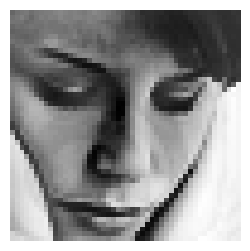

In [15]:
show_row(rescale_row(df_scaled.iloc[42]))

El siguiente paso para preprocesamiento es realizar un PCA (análisis de componentes principales) para realizar una reducción de dimensionalidad.

Primero, hacemos un análisis para ver cuánta información perdemos según el número de componentes que elijamos:

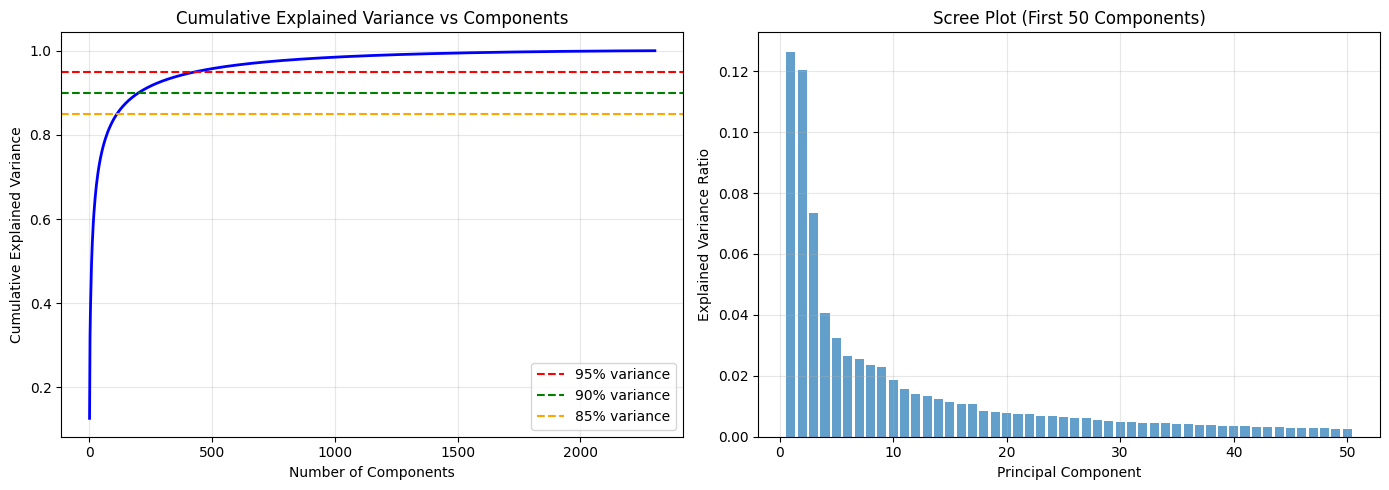

Components needed for 85% variance: 113
Components needed for 90% variance: 201
Components needed for 95% variance: 433


In [16]:
pca_full = PCA(random_state=42)
pca_full.fit(df_scaled)

# Plot cumulative explained variance
cv = np.cumsum(pca_full.explained_variance_ratio_)
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Cumulative explained variance
axs[0].plot(range(1, len(cv) + 1), cv, "b-", linewidth=2)
axs[0].axhline(y=0.95, color="r", linestyle="--", label="95% variance")
axs[0].axhline(y=0.90, color="g", linestyle="--", label="90% variance")
axs[0].axhline(y=0.85, color="orange", linestyle="--", label="85% variance")
axs[0].set_xlabel("Number of Components")
axs[0].set_ylabel("Cumulative Explained Variance")
axs[0].set_title("Cumulative Explained Variance vs Components")
axs[0].legend()
axs[0].grid(True, alpha=0.3)

# Plot 2: Scree plot (individual variance per component)
axs[1].bar(range(1, 51), pca_full.explained_variance_ratio_[:50], alpha=0.7)
axs[1].set_xlabel("Principal Component")
axs[1].set_ylabel("Explained Variance Ratio")
axs[1].set_title("Scree Plot (First 50 Components)")
axs[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Find number of components for different variance thresholds
for threshold in [0.85, 0.90, 0.95]:
    n_components = np.argmax(cv >= threshold) + 1
    print(f"Components needed for {threshold * 100:.0f}% variance: {n_components}")

Con esto podemos ver que utilizar 201 componentes nos permite conservar el 95% de la varianza, así que vamos a proceder a realizar el PCA con 201 componentes.

In [40]:
n_components = 201
pca = PCA(n_components=n_components, random_state=42, whiten=False)
df = pd.DataFrame(
    pca.fit_transform(df_scaled), index=df_scaled.index, columns=[f"PC{i + 1}" for i in range(n_components)]
)

print(f"Original shape: {df_scaled.shape}")
print(f"PCA shape: {df.shape}")
print(
    f"Variance explained: {pca.explained_variance_ratio_.sum():.4f} ({pca.explained_variance_ratio_.sum() * 100:.2f}%)"
)
print(
    f"Dimensionality reduction: {df_scaled.shape[1]} → {df.shape[1]} ({df.shape[1] / df_scaled.shape[1] * 100:.1f}% of original)"
)

Original shape: (33693, 2304)
PCA shape: (33693, 201)
Variance explained: 0.8999 (89.99%)
Dimensionality reduction: 2304 → 201 (8.7% of original)


Finalmente, a continuación una función que nos permite visualizar las imágenes después de todo el preprocesamiento, incluyendo PCA.

In [41]:
def rescale_row_pca(row: ArrayLike) -> NDArray[np.uint8]:
    """
    Reverts PCA and standardized pixel values to [0, 255] range for visualization.
    """
    pca_components = np.asarray(row, dtype=np.float64).reshape(1, -1)
    reconstructed = pca.inverse_transform(pca_components)[0]
    return rescale_row(reconstructed)

Aquí podemos verla en uso:

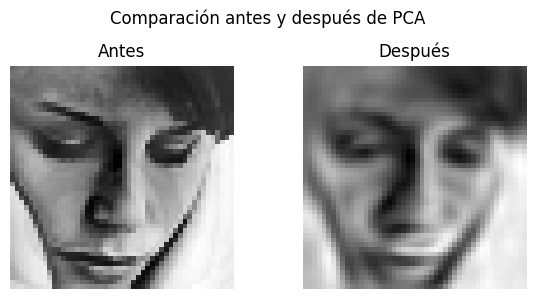

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))

show_row(rescale_row(df_scaled.iloc[42]), ax=axs[0])
axs[0].set_title("Antes")
show_row(rescale_row_pca(df.iloc[42]), ax=axs[1])
axs[1].set_title("Después")

plt.suptitle("Comparación antes y después de PCA")
plt.tight_layout()
plt.show()

## Diseño experimental

Primer definimos un `dataclass` para almacenar los resultados de la ejecución de los algoritmos de _clustering_.

In [51]:
@dataclass(slots=True, frozen=True)
class ClusterResult:
    algorithm: Literal["K-Means", "Gaussian Mixture"]
    k: int
    silhouette: float
    davies_bouldin: float
    inertia: float | None = None  # Solo K-Means
    bic: float | None = None  # Solo GMM
    aic: float | None = None  # Solo GMM

Luego procedemos a ejecutar los algoritmos de _clustering_ para valores de $k$ entre $2$ y $20$, ambos inclusive. Los algoritmos seleccionados son K-Means y Gaussian Mixture. Las métricas internas seleccionadas son el _silhouette score_ y el _Davies-Bouldin score_, a como mencionamos anteriormente.

In [52]:
x = df.to_numpy()

ks = range(2, 21)  # [2, 20]
results: list[ClusterResult] = []

# K-Means
for k in ks:
    km = KMeans(
        n_clusters=k,
        random_state=42,
        n_init="auto",  # Ejecuta varias veces para escoger la mejor inicialización.
        init="k-means++",  # Inicializar centroides lejos entre sí.
        max_iter=500,
        algorithm="elkan",
    )
    labels = km.fit_predict(x)
    sil = silhouette_score(x, labels, sample_size=min(10_000, len(x)), random_state=42)
    db = davies_bouldin_score(x, labels)
    results.append(
        ClusterResult(
            algorithm="K-Means",
            k=k,
            silhouette=sil,
            davies_bouldin=db,
            inertia=km.inertia_,
        )
    )

# Gaussian Mixture
for k in ks:
    gmm = GaussianMixture(
        n_components=k,
        random_state=42,
        n_init=5,  # Ejecuta varias veces para tomar la mejorar inicialización.
        covariance_type="spherical",  # Usar covarianzas diagonales para mayor estabilidad en alta dimensionalidad.
        max_iter=500,
        tol=1e-3,
        reg_covar=1e-6,
        init_params="kmeans",
    )
    labels = gmm.fit_predict(x)
    sil = silhouette_score(x, labels, sample_size=min(10_000, len(x)), random_state=42)
    db = davies_bouldin_score(x, labels)
    results.append(
        ClusterResult(
            algorithm="Gaussian Mixture",
            k=k,
            silhouette=sil,
            davies_bouldin=db,
            bic=gmm.bic(x),
            aic=gmm.aic(x),
        )
    )

A continuación podemos ver una tabla con los resultados obtenidos:

In [53]:
results_df = pd.DataFrame(results)
display(results_df)

,algorithm,k,silhouette,davies_bouldin,inertia,bic,aic
0,K-Means,2,0.094442,3.046090,6.320377e+07,NaN,NaN
1,K-Means,3,0.089201,2.622464,5.838885e+07,NaN,NaN
2,K-Means,4,0.064056,2.911489,5.649069e+07,NaN,NaN
3,K-Means,5,0.070112,2.789385,5.459976e+07,NaN,NaN
4,K-Means,6,0.066364,2.891515,5.349222e+07,NaN,NaN
5,K-Means,7,0.059807,3.000179,5.272455e+07,NaN,NaN
6,K-Means,8,0.053074,2.825493,5.177362e+07,NaN,NaN
7,K-Means,9,0.041823,2.965475,5.116692e+07,NaN,NaN
8,K-Means,10,0.039883,2.993931,5.060553e+07,NaN,NaN
9,K-Means,11,0.039594,3.089016,5.020904e+07,NaN,NaN


Y aquí podemos ver los mejores `k` según cada métrica y algoritmo:

In [54]:
best_sil = results_df.loc[results_df.groupby("algorithm")["silhouette"].idxmax()]
best_db = results_df.loc[results_df.groupby("algorithm")["davies_bouldin"].idxmin()]
display(best_sil)
display(best_db)

,algorithm,k,silhouette,davies_bouldin,inertia,bic,aic
20,Gaussian Mixture,3,0.083251,2.620057,NaN,3.384403e+07,3.383890e+07
0,K-Means,2,0.094442,3.046090,6.320377e+07,NaN,NaN


,algorithm,k,silhouette,davies_bouldin,inertia,bic,aic
20,Gaussian Mixture,3,0.083251,2.620057,NaN,3.384403e+07,3.383890e+07
1,K-Means,3,0.089201,2.622464,5.838885e+07,NaN,NaN


### Interpretación de resultados

Con la configuración de **PCA al 90% de varianza sin _whitening_**, los resultados son los siguientes:

- **K-Means** obtiene el mayor _Silhouette_ en $k = 2$ ($\approx 0.094$) con _Davies–Bouldin_ $\approx 3.05$. Para $k = 3$, el _Silhouette_ baja ligeramente ($\approx 0.089$) pero _Davies–Bouldin_ mejora ($\approx 2.62$). En general, los valores son pequeños pero positivos, lo que sugiere separación débil pero presente.
- **Gaussian Mixture** muestra un comportamiento razonable sin _whitening_: alcanza su mejor zona cerca de $k = 3$ con _Silhouette_ $\approx 0.083$ y _Davies–Bouldin_ $\approx 2.62$.

En conjunto, la estructura en el espacio de características sigue siendo tenue, pero consistente en el rango $k \in [2, 3]$. Con estos resultados, **K-Means** en $k = 2$ maximiza _Silhouette_, mientras que **Gaussian Mixture** prefiere $k = 3$ con valores muy similares de _Davies–Bouldin_.

## Criterio del codo

A continuación graficamos el criterio del codo para cada algoritmo: para **K-Means** usamos la inercia (_WCSS_; menor es mejor) y para **Gaussian Mixture** usamos **BIC** y **AIC** (menor es mejor).

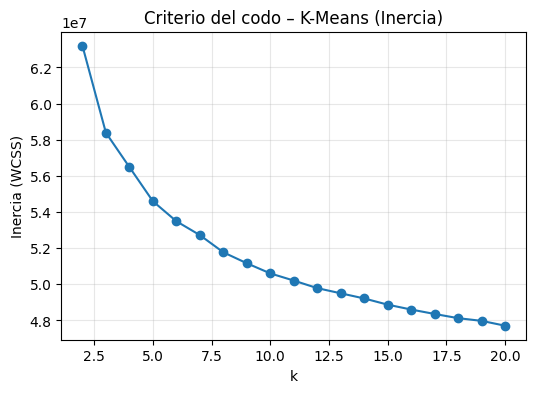

In [55]:
km_df = results_df[results_df["algorithm"] == "K-Means"].sort_values("k")

plt.figure(figsize=(6, 4))
plt.plot(km_df["k"], km_df["inertia"], marker="o")
plt.xlabel("k")
plt.ylabel("Inercia (WCSS)")
plt.title("Criterio del codo – K-Means (Inercia)")
plt.grid(True, alpha=0.3)
plt.show()

**Interpretación:** el gráfico de inercia para **K-Means** decrece de forma monótona con una caída más pronunciada entre $k=2$ y $k=4$, y mejoras cada vez más pequeñas a partir de ahí. No se observa un “codo” muy marcado, pero sí un punto de rendimientos decrecientes alrededor de $k \in [2, 4]$. Esto es coherente con las métricas internas: _Silhouette_ favorece $k=2$ y _Davies–Bouldin_ mejora levemente cerca de $k=3$.

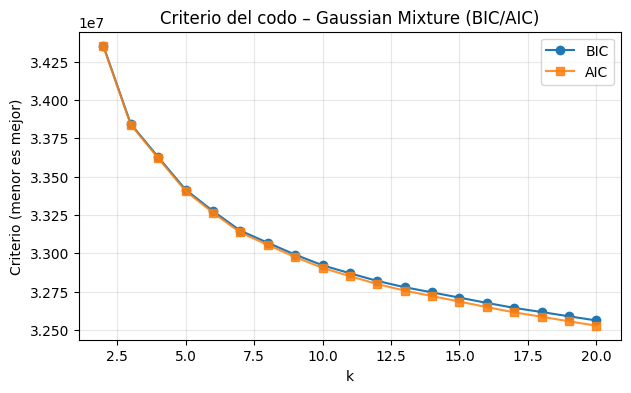

In [56]:
gmm_df = results_df[results_df["algorithm"] == "Gaussian Mixture"].sort_values("k")

plt.figure(figsize=(7, 4))
plt.plot(gmm_df["k"], gmm_df["bic"], marker="o", label="BIC")
plt.plot(gmm_df["k"], gmm_df["aic"], marker="s", label="AIC", alpha=0.85)
plt.xlabel("k")
plt.ylabel("Criterio (menor es mejor)")
plt.title("Criterio del codo – Gaussian Mixture (BIC/AIC)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Interpretación:** en **Gaussian Mixture**, tanto **BIC** como **AIC** disminuyen de forma casi lineal a medida que aumenta $k$, sin un codo claro. Dado que estos criterios penalizan la complejidad pero aún así siguen bajando, la mejora que se obtiene al aumentar $k$ es gradual. En este contexto, y considerando las métricas internas, una elección parsimoniosa alrededor de $k=3$ resulta razonable.

___

# Parte 2  - Breve artículo científico
- Debe escribir un breve artículo científico sobre su trabajo.
- El artículo se debe confeccionar en LaTeX, formato de IEEE Transactions.
- Debe incluir al menos:
  - Título
  - Autores y afiliaciones
  - Resumen
  - Palabras claves
  - Introducción
  - Trabajos relacionados - Estado del arte
  - Conceptos claves (Background)
  - Materiales y métodos.
  - Resultados
  - Análisis de resultados
  - Conclusiones
  - Trabajo Futuro
- Debe aportar las fuentes LATEX y el PDF con su artículo.
- Puede ser en español o inglés, no combinar.

## Criterios de evaluación:
1. Cuaderno de Jupyter con la implementación de su Diseño Experimental. Incluyendo todos los archivos necesarios para correr su propuesta. (**70 puntos**)
1. Breve artículo científico sobre su experimentación. Incluyendo las fuentes LATEX y el PDF.  (**30 puntos**)
1. **Recuerde que es requisito de presentación**, declarar el uso de herramientas de IA. Algo como:
    > Nota aclarativa: “He utilizado las siguientes herramientas de IA: [nombre y versión]. Su uso se limitó a [describir brevemente el propósito]. Todo el contenido ha sido revisado, verificado y complementado con mi aporte personal.”